#**Solubility-calculations-with-ML-algorithms (Part 1)**


---




**Comparison of Predictive Models of Machine Learning and Artificial Neural Networks for Solubility Prediction Based on Physicochemical Descriptors for Organic Molecules and Their Improvement Using Quantum-Chemical Descriptors (Electrostatic Potential on the Van der Waals Surface) and an ensemble learning model**

In this project, the solubility of organic molecules is predicted using various Machine Learning algorithms and Neural Networks, starting from a set of molecular physicochemical descriptors (obtained with RDKit) as the feature space and solubility data as the targets. The performance of these models is compared with experimental values obtained in the laboratory to evaluate which model is more efficient at predicting the solubility of the molecules in an aqueous medium.

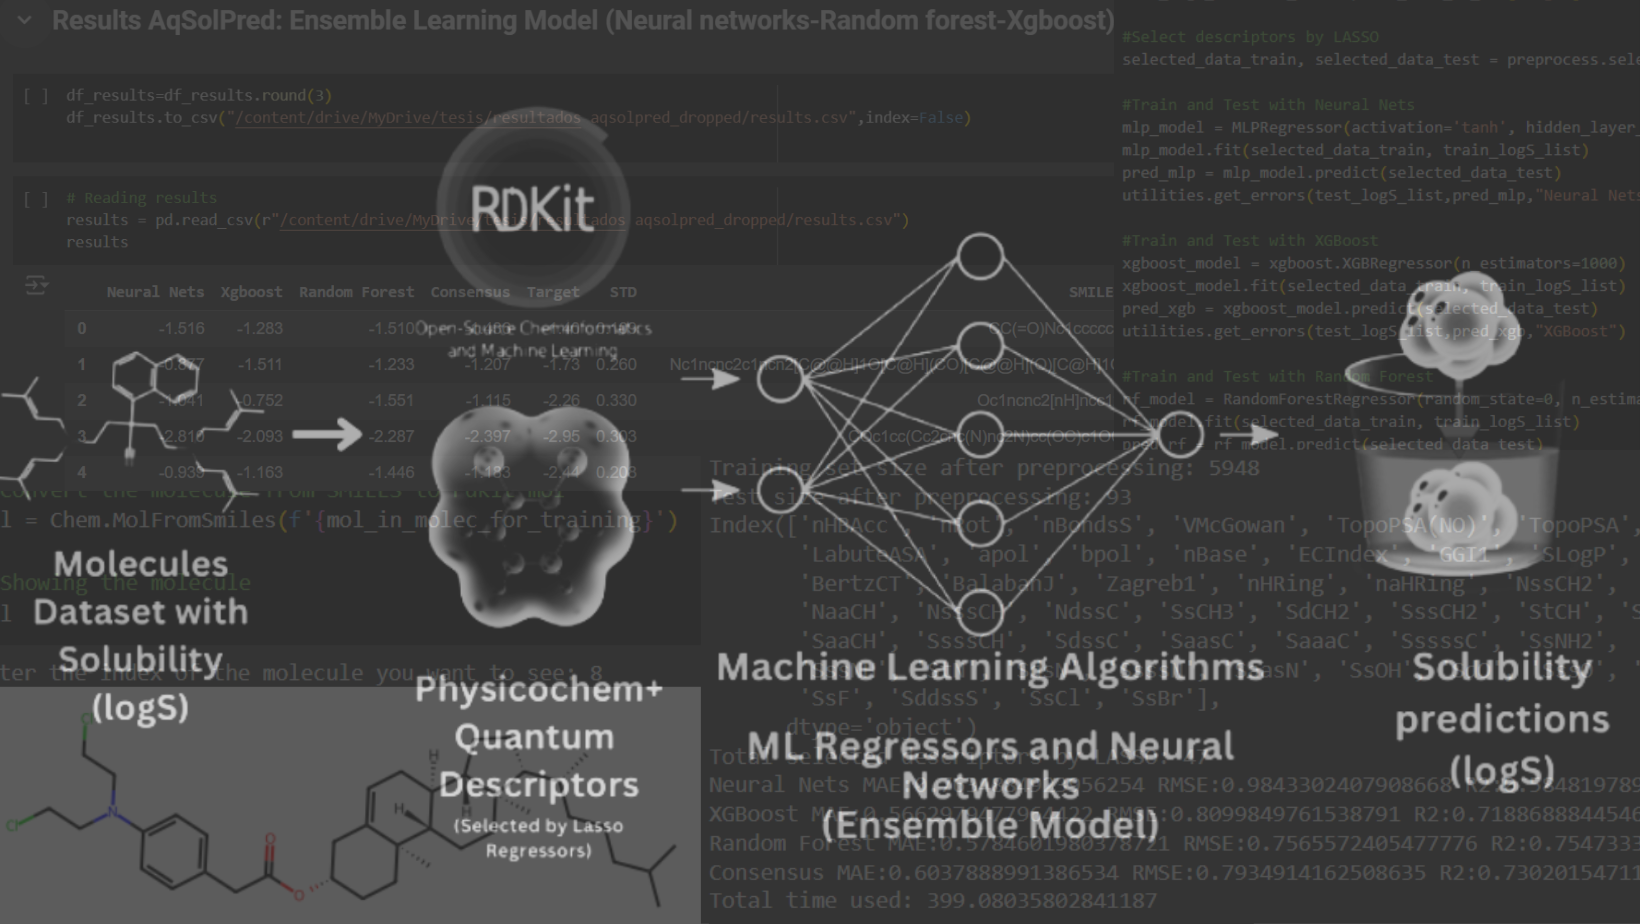

By Josué Gómez-Torales

Find me on github: josuegomezt



## **Brief Explanation for Chemists and Non-Chemists:**

The solubility of a generic compound AB, according to the International Union of Pure and Applied Chemistry (IUPAC), is defined as: The analytical composition of a saturated solution, expressed in terms of the proportion of a designated solute in a designated solvent, is the solubility of that solute.

In this context, solubility $S$ is expressed as the amount of a compound, which we call the solute, dissolved in another substance called the solvent. This can be expressed in units of matter per volume (mol/L). These units are defined by chemists as concentration. Also, solubility is related with another quantity called solubility product $K_{sp}$

Additionally, for a compound
𝐴
𝐵
AB that dissociates in water as

$$A_aB_b (s) \rightleftharpoons aA^{m+} (aq) + bB^{n-} (aq)$$
we can mathematically define the solubility product as : $$K_{\text{sp}} = [A^{m+}]^a [B^{n-}]^b$$

If the molar solubility of the compound $A_aB_b$ is $S$ in $mol/L$, then the ion concentrations at equilibrium will be:

$$[A^{m+}] = aS \quad \text{and} \quad [B^{n-}] = bS$$

Substituting these concentrations into the solubility product expression, we
obtain:

$$K_{\text{sp}} = (aS)^a (bS)^b = a^a b^b S^{a+b}$$

To calculate the solubility in terms of $log S$, we first solve for $S$ from the above expression:

$$S = \left( \frac{K_{\text{sp}}}{a^a b^b} \right)^{\frac{1}{a+b}}$$

Finally, the value of $log S$ is:

$$log S = \frac{1}{a+b} \log \left( \frac{K_{\text{sp}}}{a^a b^b} \right)$$



In this project, the solubility of organic molecules (as $logS$) is predicted using various Machine Learning algorithms and Neural Networks, starting from a set of molecular physicochemical descriptors (obtained with RDKit python library) as the feature space and solubility data as the targets. The performance of these models is compared with experimental values obtained in the laboratory to evaluate which model is more efficient at predicting the solubility of the molecules in an aqueous medium.

Finally, **methodologies for improving the results are proposed.** ***One approach is based on the ensemble model*** suggested by Sorkun et al. (iScience 24, 101961, January 22, 2021. DOI: 10.1016/j.isci.2020.101961), ***where solubility prediction is enhanced by averaging the results from three Machine Learning models (Neural Networks, XGBoost, and Random Forest)***. In this approach, the physicochemical descriptors are selected through Lasso regression to use only those relevant to the prediction task, thereby refining the feature space and improving the model's accuracy. ***Another approach is inspired by***  the work of Yao et al. (Journal of Materials Chemistry A 10(30), January 2022. DOI: 10.1039/D2TA03728A), which proposes ***calculating the electrostatic potentials on the Van der Waals surface of the training compounds. These electrostatic potentials are then provided as features to the Machine Learning algorithms.*** By offering a more accurate description of the interactions between the molecules of a given compound, this method helps improve the model’s performance in solubility prediction.

In this project, the goal is to combine the two approaches mentioned in these papers, with the hope of achieving even better results. The project is ongoing; currently, this is the pipeline being followed and the insights gained so far. The utility of this project lies in accelerating the discovery of electroactive materials for the design of redox flow batteries (RFBs) focused on clean energy.

***References:***

* Sorkun et al., iScience 24, 101961, January 22, 2021. DOI: 10.1016/j.isci.2020.101961
* Yao et al., Journal of Materials Chemistry A 10(30), January 2022. DOI: 10.1039/D2TA03728A
* Li, Y., et al. (2020). Improved Prediction of Aqueous Solubility of Novel Compounds by Going Deeper With Deep Learning. Frontiers in Oncology, 10, 121. DOI: 10.3389/fonc.2020.00121


# **Installing and importing required Libraries**

### **Installing libraries**

In [1]:
# Installing rdkit (for chemical data)
! pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.5 MB/s eta 0:00:00


In [51]:
# Installing tabulate (for displaying tables)
! pip install tabulate

In [2]:
# Installing lazypredict (for Machine Learning models bechmarking)
! pip install lazypredict


### **Importing libraries**

In [3]:
# Import for suppressing warnings and achieving clean outputs
import warnings
warnings.filterwarnings("ignore")

# Importing libraries for data manipulation and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn

# Importing libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

# Importing LazyPredict for automated model training and evaluation
import lazypredict
from lazypredict.Supervised import LazyRegressor

# Importing libraries for manipulation of chemical data
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.ML.Descriptors import MoleculeDescriptors

# Machine learning imports
from tqdm import tqdm

# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Data Preprocessing**




## **Cleaning training set**

The training dataset for the 9943 molecules was taken from the paper "Improved Prediction of Aqueous Solubility of Novel Compounds by Going Deeper With Deep Learning," published in Frontiers in Oncology. This study provides a comprehensive dataset and methodology for predicting the solubility of novel compounds using deep learning techniques, which was instrumental for our project.

***Reference:***

* Li, Y., et al. (2020). Improved Prediction of Aqueous Solubility of Novel Compounds by Going Deeper With Deep Learning. Frontiers in Oncology, 10, 121. DOI: 10.3389/fonc.2020.00121

In [4]:
# Open file with molecules which descriptors are going to be calculated for the training set
molec_for_training = pd.read_csv(r"/content/drive/MyDrive/tesis/Solubility ML/Aqueous solubility_9945.csv")
# Calculate null values for SMILES (SMILES are the computational representation for each molecule)
molec_for_training.SMILES.isnull().sum()
# Remove NaN values from the dataset
molec_for_training.dropna(inplace=True)
# Showing dataframe
molec_for_training

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85
...,...,...,...,...,...,...
9938,C1664,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1.22,0.09,60.05
9939,C1665,HDZGCSFEDULWCS-UHFFFAOYSA-N,CNN,1.34,0.17,46.07
9940,C1666,OKKJLVBELUTLKV-UHFFFAOYSA-N,CO,1.57,-0.39,32.04
9941,C1667,DLFVBJFMPXGRIB-UHFFFAOYSA-N,CC(=O)N,1.58,0.19,59.07


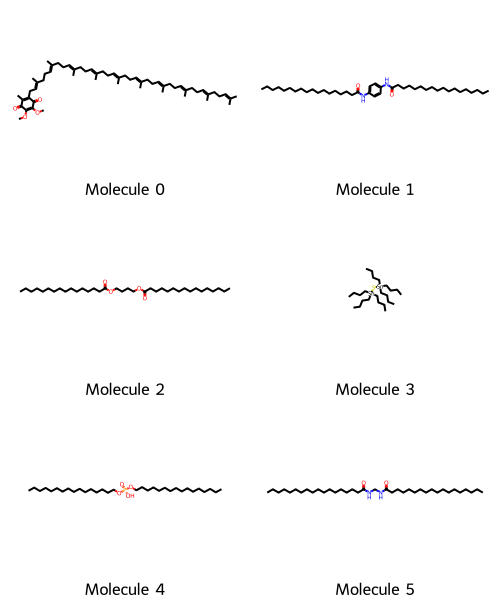

In [5]:
# Showing some molecules in the dataset (first 100 molecules)

# Generating a list of molecules to display
molec_for_training_list = [Chem.MolFromSmiles(x) for x in molec_for_training['SMILES']]

# For every molecule in the list, compute the corresponding 2D coordinates
for m in molec_for_training_list:
    tmp=AllChem.Compute2DCoords(m,bondLength=1.0)
    # For every molecule in molec_for_training_list, establish its name and index
    ind = molec_for_training_list.index(m)
    # Establishing the propertie 'Name' as string "Molecule" and its index
    m.SetProp("Name",'Molecule %d' %(ind))

# Show a legend with the property 'Name'
legends = ['%s' %(x.GetProp('Name')) for x in molec_for_training_list]

# Drawing the list of molecules
img_molec_for_training = Draw.MolsToGridImage(
    # List of molecules to draw
    molec_for_training_list,
    # Molecules to draw per row
    molsPerRow=2,
    # Size of the substructures
    subImgSize=(250,200),
    # Size of the figure
    legends=legends,
    # Maximum number of molecules to draw
    maxMols=6)

# Display the figure
img_molec_for_training

Enter the index of the molecule you want to see: 5


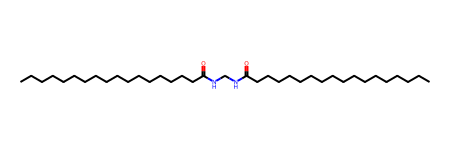

In [6]:
# prompt a molecule from the dataset by its index
index= int(input("Enter the index of the molecule you want to see: "))

# Retrieving SMILES (simplified molecular input line entry system) for the molecule from the dataset
mol_in_molec_for_training = molec_for_training.iloc[index, 2]

# Convert the molecule from SMILES to rdkit mol
mol = Chem.MolFromSmiles(f'{mol_in_molec_for_training}')

# Showing the molecule
mol

### **Removing outliers (training set)**

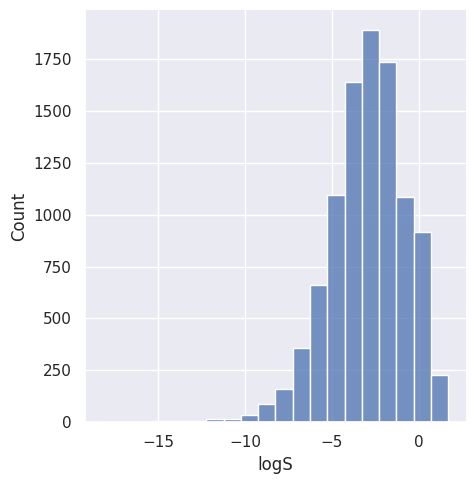

In [7]:
# Create a histogram
# Left-skewed or negatively skewed
sn.set_theme()
sn.displot(data=molec_for_training, x="logS", binwidth=1)

**It will be useful later for the training dataset to have a normal distribution because of the imputation process based on the mean that we will perform on the NaN values. This is done to prepare the data for use with neural networks (MLP Regressor). Therefore, we select compounds that approximate a normal distribution.**


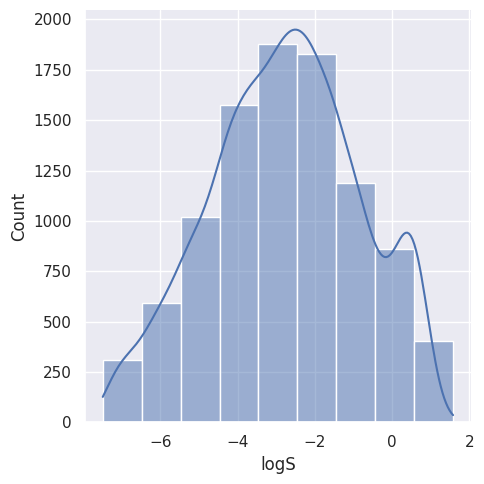

In [8]:
# Select compounds that approximate a normal distribution and update the dataset
molec_for_training = molec_for_training[molec_for_training.logS.apply(lambda x: x > -7.5 and x < 1.7)]
# Create a histogram
sn.displot(data=molec_for_training, x='logS', binwidth=1,kde=True)

<Axes: xlabel='logS'>

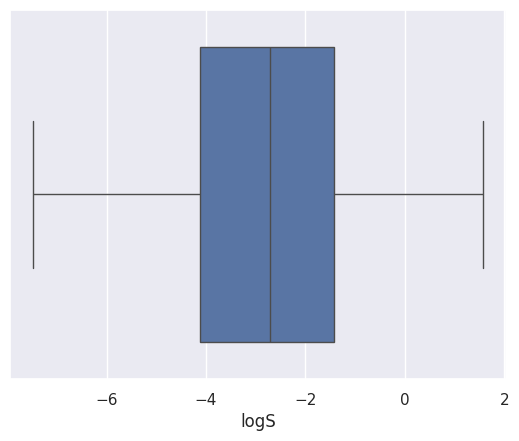

In [9]:
# Boxplot
sn.boxplot(data=molec_for_training, x='logS')

### **Removing duplicated SMILES (training set)**

In [10]:
# Function that generates canonical SMILES
def canonical_SMILES(smiles):
    canon_smi = [Chem.CanonSmiles(smi) for smi in smiles]
    return canon_smi

In [11]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(molec_for_training.SMILES)

# Replace SMILES column with Canonical SMILES
molec_for_training["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = molec_for_training[molec_for_training['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

In [12]:
# filter the duplicate smiles and sort them based on smiles
molec_for_training[molec_for_training['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,InChIKey,SMILES,logS,logP,MW
5683,C1698,WUBBRNOQWQTFEX-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44,1.00,222.25
5836,C943,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.36,1.00,222.25
7282,C7745,VWPOSFSPZNDTMJ-UCWKZMIHSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.57,1.03,309.40
8063,C1707,IWVCMVBTMGNXQD-PXOLEDIWSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.01,1.03,309.40
1345,C199,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
1347,C1673,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
5152,C1696,QZUDBNBUXVUHMW-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.70,3.10,253.28
5319,C843,JLKIGFTWXXRPMT-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.62,3.10,253.28
3918,C604,NXFQHRVNIOXGAQ-YCRREMRBSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.38,0.86,238.16
4159,C1690,NXFQHRVNIOXGAQ-OQFOIZHKSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.24,0.86,238.16


In [13]:
# Drop rows that contain duplicate SMILES and keep the first Structure
cleaned_mol_for_training = molec_for_training.drop_duplicates(subset=['SMILES'], keep='first')
len(cleaned_mol_for_training)

9642

## **Cleaning test set**

### **Open the test dataset**


The test dataset was taken from the paper "Is Experimental Data Quality the Limiting Factor in Predicting the Aqueous Solubility of Druglike Molecules?" published in Molecular Pharmaceutics. This study investigates the impact of experimental data quality on the prediction accuracy of aqueous solubility for druglike molecules, providing valuable insights for our test set.

***Reference:***

Palmer, D. S., & Mitchell, J. B. O. (2014). Is Experimental Data Quality the Limiting Factor in Predicting the Aqueous Solubility of Druglike Molecules? Molecular Pharmaceutics, 11(8), 2962–2972. DOI: 10.1021/mp500103r

In [14]:
# Reading the dataset
test_set = pd.read_csv(r"/content/drive/MyDrive/tesis/Solubility ML/Drug_Like_Solubility _100.csv")
test_set

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44
...,...,...,...
95,Sulfanilamide,O=S(=O)(c1ccc(N)cc1)N,-1.36
96,Gliclazide,O=S(=O)(c1ccc(cc1)C)NC(=O)NN3CC2CCCC2C3,-4.29
97,Trihexyphenidyl,OC(c1ccccc1)(CCN2CCCCC2)C3CCCCC3,-5.20
98,Triphenylene,c1ccc2c(c1)c3ccccc3c4c2cccc4,-6.73


### **Filtering duplicated SMILES**

In [15]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(test_set.SMILES)

# Replace SMILES column wit Canonical SMILES
test_set["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_test_smiles = test_set[test_set['SMILES'].duplicated()]['SMILES'].values
len(duplicate_test_smiles)

0

## **Drop molecules in training set that are present in the test set**

In [16]:
# Molecules used in training and test of the model
test_set_SMILES = test_set.SMILES.values

# Filter molecules that are not present in the test set
# or exclude structures that are present in the test set from training set
cleaned_mol_for_training_final = cleaned_mol_for_training[~cleaned_mol_for_training['SMILES'].isin(test_set_SMILES)]
print(f'Compounds present in training set:{len(cleaned_mol_for_training) - len(cleaned_mol_for_training_final)}')

Compounds present in training set:93


In [17]:
# The test set compounds should within the training data distribution
test_set = test_set[test_set['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
test_set

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,CC(=O)Nc1ccccc1,-1.40
1,Adenosine,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,-1.73
2,Allopurinol,Oc1ncnc2[nH]ncc12,-2.26
3,Trimethoprim,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,-2.95
4,Acetazolamide,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44
...,...,...,...
95,Sulfanilamide,Nc1ccc(S(N)(=O)=O)cc1,-1.36
96,Gliclazide,Cc1ccc(S(=O)(=O)NC(=O)NN2CC3CCCC3C2)cc1,-4.29
97,Trihexyphenidyl,OC(CCN1CCCCC1)(c1ccccc1)C1CCCCC1,-5.20
98,Triphenylene,c1ccc2c(c1)c1ccccc1c1ccccc21,-6.73


## **Calculate all 200 RDKit physicochemical descriptors for molecules in the training dataset**

In [20]:
def RDkit_descriptors(smiles):
    """
    Calculate RDKit molecular descriptors for a list of SMILES strings.

    Parameters:
    smiles (list of str): A list of SMILES strings.

    Returns:
    tuple:
        Mol_descriptors (list of tuples): A list of tuples, where each tuple contains the molecular descriptors for a molecule.
        desc_names (tuple): A tuple containing the names of all calculated descriptors.
    """
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors = []
    for mol in tqdm(mols):
        # Add hydrogens to molecules
        mol = Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)

    return Mol_descriptors, desc_names


In [19]:
# Calculate all 200 RDKit descriptors for molecules in the training set
Mol_descriptors,desc_names = RDkit_descriptors(cleaned_mol_for_training_final['SMILES'])
# Insert the descriptors to the feature space dataframe
training_set = pd.DataFrame(Mol_descriptors,columns=desc_names)

100%|██████████| 9549/9549 [04:18<00:00, 36.90it/s] 


## **Show the training set feature space and targets**

In [21]:
# Training set feature space
training_set

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.25,-4.68,9.25,0.05,0.55,407.05,379.83,406.13,140,0,...,1,0,0,0,0,0,0,0,0,0
1,14.36,-5.72,14.36,0.00,0.41,552.49,522.25,551.14,194,0,...,0,0,0,0,0,0,0,0,0,0
2,8.72,-4.55,8.72,0.55,0.44,292.43,268.23,292.19,114,0,...,0,0,0,0,0,0,0,0,0,0
3,13.83,-5.29,13.83,0.86,0.12,702.90,656.54,702.30,262,0,...,0,0,0,0,0,0,0,0,0,0
4,8.30,-5.38,8.30,1.26,0.27,297.57,254.23,297.34,128,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9544,11.15,-5.58,11.15,3.22,0.48,138.00,130.94,137.97,32,0,...,0,0,0,0,0,0,0,0,0,0
9545,9.86,-2.79,9.86,1.50,0.43,60.05,56.02,60.02,24,0,...,0,0,0,0,0,0,0,0,0,0
9546,6.50,-2.72,6.50,0.23,0.27,46.07,40.02,46.05,20,0,...,0,0,0,0,0,0,0,0,0,0
9547,6.10,-2.54,6.10,2.54,0.39,32.04,28.01,32.03,14,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Training set targets
cleaned_mol_for_training_final.logS

,logS
294,-7.49
295,-7.49
296,-7.48
297,-7.47
298,-7.46
...,...
9937,1.16
9938,1.22
9939,1.34
9940,1.57


In [23]:
# Save the feature space and the targets to a csv
training_set.to_csv("/content/drive/MyDrive/tesis/Solubility ML/feature space/fspace.csv", index=False)
cleaned_mol_for_training_final.logS.to_csv("/content/drive/MyDrive/tesis/Solubility ML/targets/targets.csv", index=False)

# **Machine Learning models for solubility prediction**


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

def get_errors(y_true, y_pred, model_name):
    """
    Calculate and print error metrics for the given predictions.

    Parameters:
    y_true (array-like): True values of the target variable.
    y_pred (array-like): Predicted values from the model.
    model_name (str): Name of the model used for predictions.

    Returns:
    None
    """
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate Root Mean Squared Error
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    # Calculate R-squared score
    r2 = r2_score(y_true, y_pred)

    # Create data for the table
    table = [
        ["Model", "MAE", "RMSE", "R2"],
        [model_name, mae, rmse, r2]
    ]

    # Return the table for printing
    return table


In [24]:
# Reading csv files for the feature space and targets
training_set = pd.read_csv(r"/content/drive/MyDrive/tesis/Solubility ML/feature space/fspace.csv")
cleaned_mol_for_training_final = pd.read_csv(r"/content/drive/MyDrive/tesis/Solubility ML/targets/targets.csv")

## **Train-Test splitting and standarization**

In [25]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(training_set,
                                                      cleaned_mol_for_training_final.logS,
                                                      test_size=0.1,random_state=42)
# Standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## **Initial benchmarking with 42 regressors using LazyPredict**

In [26]:
# Training of the dataset was accomplished using 42 models with LazyPredict
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(X_train_scaled, X_valid_scaled, y_train, y_valid)

 98%|█████████▊| 41/42 [06:53<00:04,  4.99s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22342
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 193
[LightGBM] [Info] Start training from score -2.762630


100%|██████████| 42/42 [06:56<00:00,  9.92s/it]


In [46]:
# Display the top 3 models and their effectiveness
prediction_tests[:3]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.82,0.86,0.74,4.06
LGBMRegressor,0.81,0.85,0.75,2.68
ExtraTreesRegressor,0.81,0.85,0.76,40.13


## **GridSearch for fine-tuning the selected model**

According to Sorkun et al. (iScience 24, 101961, January 22, 2021. DOI: 10.1016/j.isci.2020.101961) one of the best models for predicting solubility is LGBM, so we are using this model in order to obtain insights of its behaviour on our dataset

In [28]:
# The best parameters obtained through grid search are: {'learning_rate': 0.04, 'max_depth': 26, 'n_estimators': 1150}
model = LGBMRegressor(n_estimators=1150, max_depth= 26, learning_rate= 0.04, random_state=42)
model.fit(X_train_scaled,y_train)
y_preds = model.predict(X_valid_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22342
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 193
[LightGBM] [Info] Start training from score -2.762630


In [29]:
# A plotting function
def plot_data(actual, predicted, title):
     # model performance using RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # R^2 (coefficient of determination) :
    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    # Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,'ls':'--','color':'red',"alpha":0.7})
    plt.title(title, color='red')
    plt.xlabel('Predicted logS(mol/L)', color='blue')
    plt.ylabel('Experimental logS(mol/L)', color ='blue')
    plt.xlim(-8,1)

    plt.grid(alpha=0.3)
    R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2, rmse])

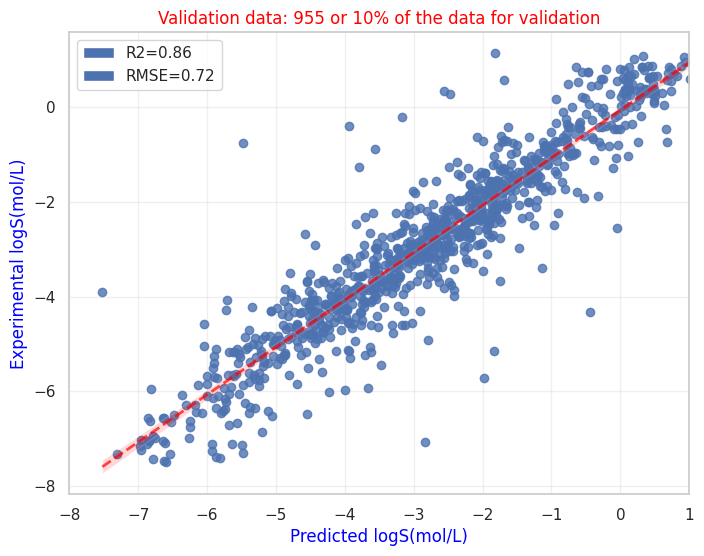

In [30]:
# Function call for plotting validation set
sn.set_theme(style="whitegrid")
plot_data(y_valid,y_preds,'Validation data: 955 or 10% of the data for validation')

In [31]:
#Calculate molecular descriptors for the test data (98 compounds)
Mol_descriptors_test,desc_names_test = RDkit_descriptors(test_set['SMILES'])
test_set_with_200_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

100%|██████████| 98/98 [00:01<00:00, 58.22it/s]


In [32]:
# Standard scaler - transform
X_scaled_test = scaler.transform(test_set_with_200_descriptors)

In [33]:
# Predict solubility of the test data
y_test_preds = model.predict(X_scaled_test)

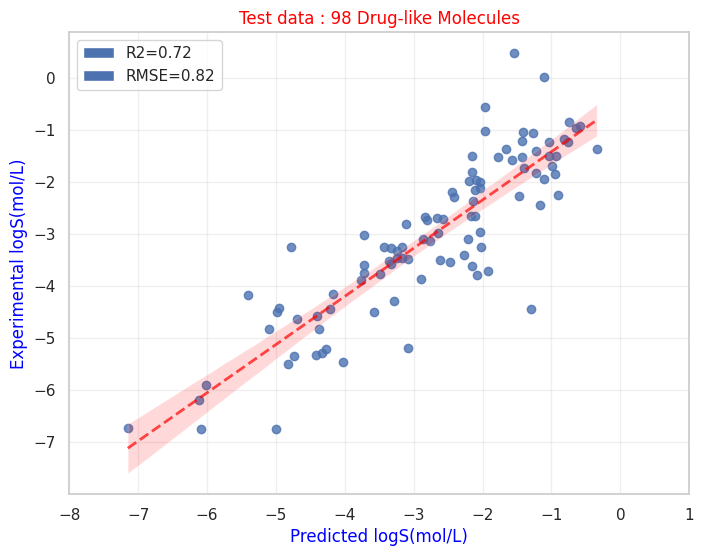

In [34]:
# function call for plotting testing set
sn.set_theme(style="whitegrid")
plot_data(test_set['LogS exp (mol/L)'], y_test_preds,
           'Test data : 98 Drug-like Molecules')

**Solubility Prediction with Machine Learning Models: LGBMRegressor**

In [35]:
import pandas as pd

# Create DataFrame with custom column names
df = pd.DataFrame({
    'Experimental logS Solubility (mol/L)': test_set['LogS exp (mol/L)'],
    'Predicted logS Solubility (mol/L) [LGBMRegressor]': y_test_preds
})

# Display the DataFrame
df


,Experimental logS Solubility (mol/L),Predicted logS Solubility (mol/L) [LGBMRegressor]
0,-1.40,-1.23
1,-1.73,-1.40
2,-2.26,-1.47
3,-2.95,-2.04
4,-2.44,-1.17
...,...,...
95,-1.36,-0.34
96,-4.29,-3.28
97,-5.20,-4.28
98,-6.73,-7.15


In [65]:
# Execute the get_errors function with the data for the LGBM Regressor predictions on the test set
errors_table = get_errors(test_set['LogS exp (mol/L)'], y_test_preds, "LGBM Regressor")

# Print the table
print(tabulate(errors_table, headers="firstrow", tablefmt="grid"))


+----------------+---------+----------+----------+
| Model          |     MAE |     RMSE |       R2 |
+================+=========+==========+==========+
| LGBM Regressor | 0.59163 | 0.817401 | 0.721365 |
+----------------+---------+----------+----------+


# **Solubility with Neural Networks**

Given the approach discussed in Sorkun et al. (iScience 24, 101961, January 22, 2021. DOI: 10.1016/j.isci.2020.101961), which involves an ensemble model using XGBoost, Neural Networks, and Random Forest, it is particularly interesting to examine the predictions made by Neural Networks on the test set. This is noteworthy because, as mentioned in the study, Neural Networks alone tend to produce less favorable results compared to other models.

## **Libraries**

In [37]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.neural_network import MLPRegressor


## **Functions**

In [38]:
def get_errors(y_true,y_pred,model_name="Model"):

    err_mae=mae(y_true,y_pred)
    err_rmse=np.sqrt(mse(y_true,y_pred))
    err_r2=r2(y_true,y_pred)

    print(model_name+" MAE:"+str(err_mae)+" RMSE:"+str(err_rmse)+" R2:"+str(err_r2))

    return err_mae,err_rmse,err_r2

## **Data Preprocessing**

In [41]:
# Preparing training data (features and target)
X_train = training_set
y_train = cleaned_mol_for_training_final.logS


In [42]:
# Impute Nan values in the feature space
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# create a new dataframe
X_train_cleaned = pd.DataFrame(X_train_imputed, columns=X_train.columns)


In [43]:
# Data standarization
scaler = StandardScaler()

# Adjuts scaler with training set and transform
X_train_scaled = scaler.fit_transform(X_train_cleaned)


## **Setting Neural Networks**

In [44]:
# Setting Neural nets
mlp_model = MLPRegressor(
    activation='tanh',
    hidden_layer_sizes=(500,),
    max_iter=500,
    random_state=0,
    solver='adam'
)

# Training the model
mlp_model.fit(X_train_scaled, y_train)

MLPRegressor(activation='tanh', hidden_layer_sizes=(500,), max_iter=500,
             random_state=0)

In [47]:
# Transformar el conjunto de prueba con el scaler ajustado
X_test_scaled = scaler.transform(test_set_with_200_descriptors)

# Realizar predicciones
pred_mlp = mlp_model.predict(X_test_scaled)


**Solubility Prediction with Neural Networks**

In [49]:
import pandas as pd

# Create DataFrame with custom column names
df = pd.DataFrame({
    'Experimental logS Solubility (mol/L)': test_set['LogS exp (mol/L)'],
    'Predicted logS Solubility (mol/L) [MLP Neural Networks Hyperbolic Regressor]': pred_mlp
})

# Display the DataFrame
df


,Experimental logS Solubility (mol/L),Predicted logS Solubility (mol/L) [MLP Neural Networks Hyperbolic Regressor]
0,-1.40,-1.23
1,-1.73,-1.68
2,-2.26,-1.78
3,-2.95,-1.76
4,-2.44,-1.45
...,...,...
95,-1.36,-0.24
96,-4.29,-4.49
97,-5.20,-5.08
98,-6.73,-6.19


In [63]:
# Execute the get_errors function with the data for the neural network predictions on the test set
errors_table = get_errors(test_set['LogS exp (mol/L)'], pred_mlp, "Neural Nets")

# Print the table
print(tabulate(errors_table, headers="firstrow", tablefmt="grid"))

+-------------+----------+---------+----------+
| Model       |      MAE |    RMSE |       R2 |
+=============+==========+=========+==========+
| Neural Nets | 0.635931 | 0.85523 | 0.694978 |
+-------------+----------+---------+----------+


# **Conclusions**

Based on the error metrics obtained for each regressor, ***we can draw the following conclusions:***

**The performance of the LGBM Regressor shows better results compared to the Neural Nets model for predicting solubility values (logS).** Specifically:

LGBM Regressor has a Mean Absolute Error (MAE) of 0.59163 and a Root Mean Squared Error (RMSE) of 0.817401, with an R-squared (R2) score of 0.721365.
Neural Nets shows a MAE of 0.635931, an RMSE of 0.85523, and an R2 score of 0.694978.
The lower MAE and RMSE, along with the higher R2 score, indicate that the LGBM Regressor provides more accurate and reliable predictions of solubility compared to the Neural Nets model. Thus, the LGBM Regressor is preferred for this prediction task.

# **Insights**

In this script, the benchmarking of the project for predicting solubility in aqueous media for organic molecules was conducted, with a focus on the accelerated discovery of electroactive materials for the design of redox flow batteries. Overall, the models yield good results; however, the input information provided about the molecules does not fully capture their properties and interactions with the solvent (water).

To address this, the pipeline includes the implementation of the ensemble model mentioned earlier (refer to Sorkun et al., iScience 24, 101961, January 22, 2021, DOI: 10.1016/j.isci.2020.101961), as well as the calculation of quantum chemical descriptors (electrostatic potential on the Van der Waals surface) (see Chuang Yao et al., Journal of Materials Chemistry A 10(30), DOI: 10.1039/D2TA03728A). These enhancements aim to provide a more comprehensive description of each molecule, aiding the models in generating better results.

It is important to note that the project is still under development, and further testing will involve combining the results into a global ensemble model, which may average or weight each input to achieve the best possible outcomes.

